# Lab CMBLenses

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [2]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [3]:
using Revise
using MCHMC

In [4]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:53
  step:        20
  logpdf:      377.00
  α:           0.008522608
  CG:          2 iterations
  Linesearch:  9 bisections


In [130]:
CMBLensingTarget2(prob; kwargs...) = begin
    d = length(prob.Ωstart)
    Λmass = real(prob.Λmass)
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = x
        xt = CMBLensing.LenseBasis(inv_sqrtΛmass * x)
        #xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = xt
        x = CMBLensing.LenseBasis(sqrtΛmass * xt)
        #x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function nlogp(xt)
        x = inv_transform(xt)
        return  -1.0 .* prob(x)
    end

    function grad_nlogp(xt)
        return CMBLensing.LenseBasis(Zygote.gradient(nlogp, xt)[1])
        #return ForwardDiff.gradient(nlogp, x)
    end

    function prior_draw(key)
        x = prob.Ωstart
        xt = transform(x)
        return CMBLensing.LenseBasis(xt)
        #return prob.Ωstart
    end

    CMBLensingTarget(d,
                     Λmass,
                     nlogp,
                     grad_nlogp,
                     transform,
                     inv_transform,
                     prior_draw)
end

CMBLensingTarget2 (generic function with 1 method)

In [131]:
CMBLensingTarget3(prob; kwargs...) = begin
    d = length(prob.Ωstart)
    Λmass = real(prob.Λmass)
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = x
        #xt = CMBLensing.LenseBasis(inv_sqrtΛmass * x)
        xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = xt
        #x = CMBLensing.LenseBasis(sqrtΛmass * xt)
        x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function nlogp(xt)
        x = inv_transform(xt)
        return -1.0 .* prob(x)
    end

    function grad_nlogp(xt)
        return CMBLensing.LenseBasis(Zygote.gradient(nlogp, xt)[1])
        #return ForwardDiff.gradient(nlogp, x)
    end

    function prior_draw(key)
        x = prob.Ωstart
        xt = transform(x)
        return CMBLensing.LenseBasis(xt)
        #return prob.Ωstart
    end

    CMBLensingTarget(d,
                     Λmass,
                     nlogp,
                     grad_nlogp,
                     transform,
                     inv_transform,
                     prior_draw)
end

CMBLensingTarget3 (generic function with 1 method)

In [132]:
target = CMBLensingTarget2(prob);
target2 = CMBLensingTarget3(prob);

## Sample

In [133]:
eps=0.1
L=sqrt(target.d)
spl=Sampler(;eps=eps, L=L)

Sampler(Settings(MersenneTwister(0), 0.1, 7.0710678118654755, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "LF"), MCHMC.Leapfrog)

In [134]:
init = MCHMC.Get_initial_conditions(spl, target)
x, g, u, r, t = init

([0.11817961931228638, 0.7882625460624695, -0.915061891078949, -1.5918281078338623, 0.4248858690261841, 1.0952790975570679, -0.601466178894043, -1.2807449102401733, 0.9124752283096313, 1.5836602449417114  …  -1.9049437464526233e-16, -4.2375006943213514e-18, 2.5941760438202236e-16, 7.301237393385877e-17, -3.152020031481085e-16, -1.306839356366479e-16, 1.3832532425629436e-16, -4.6198483888617374e-17, -1.6094379124341003, 0.0], [-0.11833284795284271, 0.1652650386095047, -0.050393424928188324, 0.003822234459221363, -0.10895784944295883, 0.17649756371974945, -0.2594493329524994, -0.05051456019282341, 0.0059846434742212296, -0.2722530961036682  …  0.02744857221841812, 0.3533375561237335, 0.2658825218677521, -0.2326851338148117, -0.22705858945846558, -0.018141543492674828, -0.02003740705549717, -0.2018553614616394, 0.07425926417218671, -0.04337666806911163], [-1.9688955035235267e-6, 2.230841801065253e-6, 1.609240030120418e-6, -1.378087176817644e-6, -2.503246605556342e-6, 5.11863618157804e-7, 

In [137]:
g

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 -0.11833284795284271
  0.1652650386095047
 -0.050393424928188324
  ⋮
  0.07425926417218671
 -0.04337666806911163

In [135]:
uu, rr = MCHMC.Update_momentum(spl, target, eps * 0.5, g, u, r)

#full step in x
xx = x .- eps .* uu
gg = target.grad_nlogp(xx)
println(gg)

[1.906825344714995e71, -6.579411329263291e71, -4.173179180454567e71, 2.364237791543158e71, -8.91255696996726e71, 6.348672757076419e71, 9.17645254378672e71, -4.036858181423023e71, 5.968352490272168e71, 1.740450851278511e71, -3.7019986545325963e71, 2.4747226864416227e71, -2.539026719115814e72, 1.0647695880212158e72, 2.5126371617338682e72, -1.2959510455865556e72, 1.5634535253804413e70, -8.679463154725332e69, -1.7230793376150234e70, 9.233819446026834e69, -1.9921308923024763e70, 1.064131145869438e70, 2.290329995068357e70, -4.838878951687967e69, 2.336364687182778e70, -1.1706958464383454e70, -2.1767388749481965e70, 1.1152602173081953e70, -2.5330288001046785e70, 1.331456812476804e70, 2.234829697338798e70, -1.911700063177445e70, -5.083367144196709e103, -9.936356954361547e103, 4.3417135529419056e103, 9.315265320390747e103, 7.533824554343515e102, 1.1724882434006381e104, -5.8636482617537165e103, -5.322325473744325e103, -3.5810073239225637e103, -1.0229865096694027e104, 2.3080200731017208e103, 1.009

In [136]:
samples = Sample(spl, target; num_steps=500)

501-element Vector{Vector{Float64}}:
 [0.11817961931228638, 0.7882625460624695, -0.915061891078949, -1.5918281078338623, 0.4248858690261841, 1.0952790975570679, -0.601466178894043, -1.2807449102401733, 0.9124752283096313, 1.5836602449417114  …  -1.9049437464526233e-16, -4.2375006943213514e-18, 2.5941760438202236e-16, 7.301237393385877e-17, -3.152020031481085e-16, -1.306839356366479e-16, 1.3832532425629436e-16, -4.6198483888617374e-17, -1.6094379124341003, 0.0]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 ⋮
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]

In [123]:
samples2 = Sample(spl, target2; num_steps=500)

501-element Vector{Vector{Float64}}:
 [0.49172186851501465, 3.3348827362060547, -3.8632519245147705, -6.717447280883789, 1.7892075777053833, 4.633310794830322, -2.5502521991729736, -5.4095892906188965, 3.8559768199920654, 6.702130317687988  …  -0.04988100752234459, -0.000928846187889576, 0.0768577978014946, 0.020462296903133392, -0.1136246994137764, -0.03365310654044151, 0.054052047431468964, -0.02620689570903778, -1.6094379124341003, 0.0]
 [0.2379595589485688, 1.6345873725150575, -1.8849869759510058, -3.273532626804273, 0.8550562770657804, 2.249687268381514, -1.2239483763018937, -2.6292612333432412, 1.881113520331609, 3.268518553836625  …  -3.986214877878885e-9, -6.345170560415898e-10, 4.626322151788062e-9, 1.3829634259181773e-9, -6.150422216308497e-9, -2.646392434188878e-9, 2.8133753161588415e-9, -4.3273227514983417e-10, -1.6213546983196543, -0.0033778378831974265]
 [0.23375566332717346, 1.6466895455811597, -1.8911470196509406, -3.2776428842760095, 0.8387393716650529, 2.2480602447423

## Plotting

In [106]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [107]:
rs = [sample[end] for sample in samples]
Aϕs = [sample[end-1] for sample in samples];

In [108]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

NaN NaN


In [109]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

NaN NaN


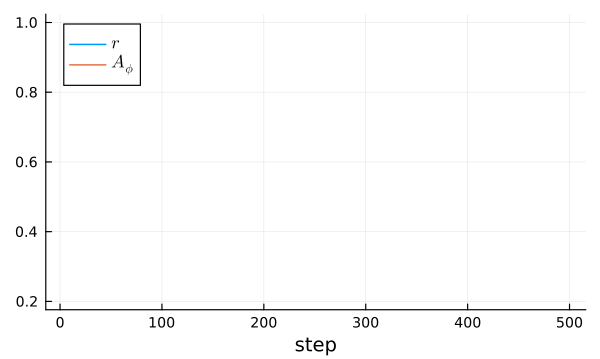

In [110]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

In [111]:
rs = [sample[end] for sample in samples2]
Aϕs = [sample[end-1] for sample in samples2];

In [112]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

1.84241425934376 1.1800459416406908


In [113]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

0.12370709656582053 0.06857087395249864


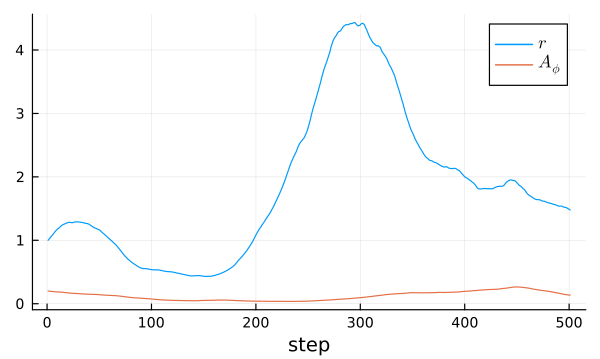

In [114]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

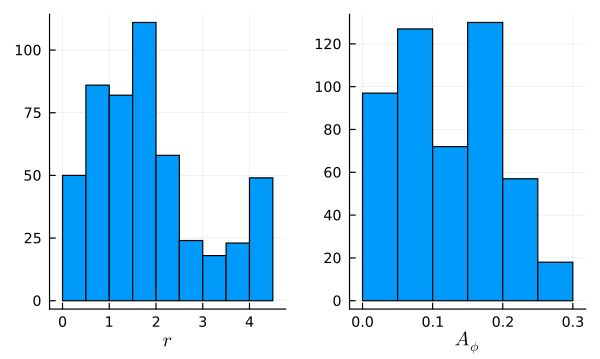

In [115]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))